In [1]:
import pandas as pd
import scipy.io
import os
import mne
from mne.channels import make_standard_montage
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
data_dir = os.path.dirname("./data/")
data_files = os.listdir(data_dir)
print('\n'.join(sorted(data_files)))

FREEFORMSubjectB1511112StLRHand.mat
FREEFORMSubjectC1512082StLRHand.mat
FREEFORMSubjectC1512102StLRHand.mat
NoMTSubjectF1604220StNoMotor.mat
NoMTSubjectH1606280StNoMotor.mat
NoMTSubjectI1605120StNoMotor.mat
NoMTSubjectJ1610260StNoMotor.mat
NoMTSubjectK1610250StNoMotor.mat
NoMTSubjectL1610260StNoMotor.mat
NoMTSubjectM1611160StNoMotor.mat


In [3]:
def annotations_from_eGUI(raw, egui):
    codes = []
    starts = []
    
    current_state = None
    
    for i in range(len(egui)):
        if egui[i][0] != current_state:
            starts.append(i)
            current_state = egui[i][0]
            codes.append(str(egui[i][0]))
    
    starts.append(len(egui))
    codes = np.array(codes)
    sf = raw.info.get('sfreq')
    starts = np.array(starts) / sf
    durations = starts[1:] - starts[:-1]
    starts = starts[:-1]
    
    raw.set_annotations(mne.Annotations(onset=starts, duration=durations, description=codes))
            

def raw_from_mat(file):
    mat = scipy.io.loadmat(os.path.join(data_dir, file))
    
    sampling_freq = mat["o"][0][0][2][0][0]
    n_samples = mat["o"][0][0][3][0][0]
    ch_names = [element[0][0] for element in mat["o"][0][0][6]]
    
    df = pd.DataFrame(mat["o"][0][0][5], columns=ch_names)
    df = df.drop(columns=["X5"])
    df = df.T
    ch_names.remove("X5")
    
    ch_types = ['eeg'] * 21
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
    raw = mne.io.RawArray(df.to_numpy(), info)
    
    montage = make_standard_montage("standard_prefixed")
    raw.set_montage(montage)
    
    raw.load_data().set_eeg_reference(ref_channels='average')
    annotations_from_eGUI(raw, mat["o"][0][0][4])
    return raw


def filter_raw(raw):
    return raw.load_data().filter(0.1, 30, method="fir", phase="zero-double")

In [4]:
# files_5f = [file for file in data_files if "5F" in file]
raw_NoMT = [raw_from_mat(file) for file in data_files if "NoMT" in file]
# files_HaLT = [file for file in data_files if "HaLT" in file]
raw_FREEFORM = [raw_from_mat(file) for file in data_files if "FREEFORM" in file]
# files_CLA = [file for file in data_files if ("CLA" in file) and (not "SubjectJ" in file)]
# files_CLA_SubjectJ = [file for file in data_files if "CLA-" in file]

Creating RawArray with float64 data, n_channels=21, n_times=664400
    Range : 0 ... 664399 =      0.000 ...  3321.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=21, n_times=664600
    Range : 0 ... 664599 =      0.000 ...  3322.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=21, n_times=662400
    Range : 0 ... 662399 =      0.000 ...  3311.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=21, n_times=667600
    Range : 0 ... 667599 =      0.000 ...  3337.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 d

In [5]:
for file in raw_FREEFORM:
    print(Counter(file.annotations.description))

Counter({'0': 741, '1': 370, '2': 369, '99': 1})
Counter({'0': 692, '1': 346, '2': 342, '99': 3})
Counter({'0': 705, '1': 350, '2': 350, '99': 4})


In [6]:
for file in raw_NoMT:
    print(Counter(file.annotations.description))

Counter({'0': 966, '5': 171, '1': 163, '2': 159, '4': 156, '3': 156, '6': 152, '99': 5, '91': 2, '92': 1})
Counter({'0': 960, '5': 169, '1': 161, '2': 157, '3': 157, '4': 155, '6': 152, '99': 5, '91': 2, '92': 1})
Counter({'0': 963, '5': 171, '1': 162, '2': 158, '3': 156, '4': 154, '6': 153, '99': 5, '91': 2, '92': 1})
Counter({'0': 968, '5': 171, '1': 163, '2': 159, '3': 158, '4': 156, '6': 152, '99': 5, '91': 2, '92': 1})
Counter({'0': 968, '5': 170, '1': 163, '2': 159, '3': 158, '4': 156, '6': 153, '99': 5, '91': 2, '92': 1})
Counter({'0': 968, '4': 180, '6': 163, '2': 163, '3': 160, '5': 155, '1': 139, '99': 5, '91': 1, '92': 1})
Counter({'0': 967, '5': 171, '1': 163, '2': 159, '3': 158, '4': 156, '6': 151, '99': 5, '91': 2, '92': 1})


In [7]:
filtered_raw_FREEFORM = [filter_raw(file) for file in raw_FREEFORM]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-12 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-12 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 sec)



[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-12 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 sec)



[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.0s finished


Using matplotlib as 2D backend.


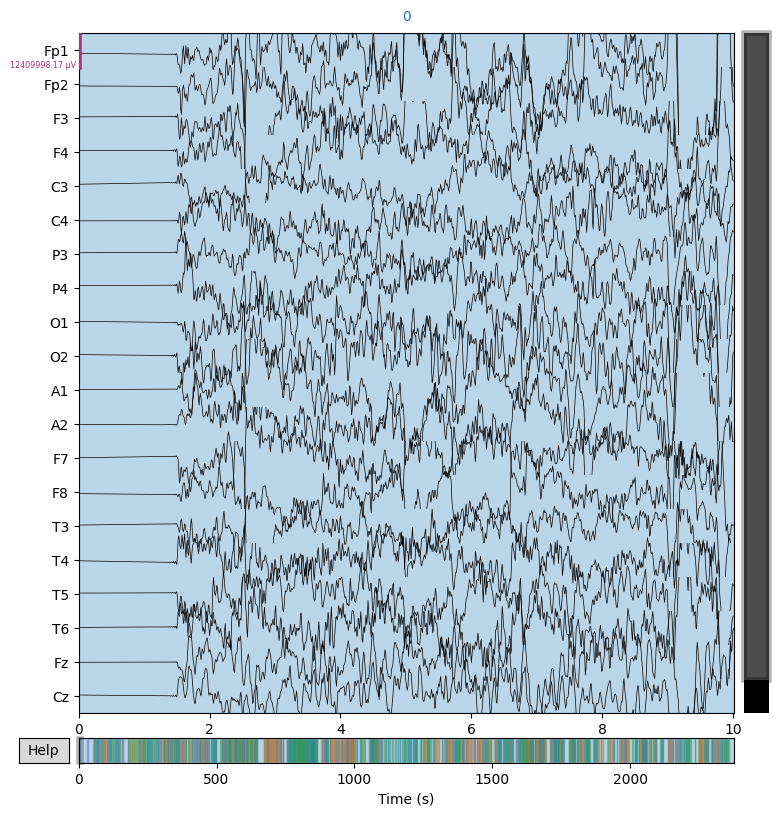

In [8]:
filtered_raw_FREEFORM[0].plot(scalings='auto')
plt.show()

# Preprocessing

In [11]:
from mne_icalabel import label_components


def apply_automated_ica(raw_obj):
    ica = mne.preprocessing.ICA(n_components=21, random_state=36, method="infomax", fit_params=dict(extended=True))
    ica.fit(raw_obj)
    ic_labels = label_components(raw_obj, ica, method="iclabel")
    labels = ic_labels["labels"]
    exclude_idx = [
        idx for idx, label in enumerate(labels) if label not in ["brain", "other"]
    ]
    print(f"Excluding these ICA components: {exclude_idx}")
    reconst_raw = raw_obj.copy()
    ica.apply(reconst_raw, exclude=exclude_idx)
    return reconst_raw


In [12]:
# Toggle these comments if you want to apply ica or not
# ica_raws_FREEFORM = [apply_automated_ica(file) for file in filtered_raw_FREEFORM]
# ica_raws_FREEFORM[0].plot(scalings="auto")

Fitting ICA to data using 21 channels (please be patient, this may take a while)
Selecting by number: 21 components
Computing Extended Infomax ICA
Fitting ICA took 69.2s.


C:\Users\alexa\AppData\Local\Temp\ipykernel_10456\3261834108.py:6: RuntimeWarning: Using n_components=21 (resulting in n_components_=21) may lead to an unstable mixing matrix estimation because the ratio between the largest (11) and smallest (6.8e-30) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 20
  ica.fit(raw_obj)
C:\Users\alexa\AppData\Local\Temp\ipykernel_10456\3261834108.py:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_obj, ica, method="iclabel")


Excluding these ICA components: [8]
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 1 ICA component
    Projecting back using 21 PCA components
Fitting ICA to data using 21 channels (please be patient, this may take a while)
Selecting by number: 21 components
Computing Extended Infomax ICA
Fitting ICA took 44.9s.


C:\Users\alexa\AppData\Local\Temp\ipykernel_10456\3261834108.py:6: RuntimeWarning: Using n_components=21 (resulting in n_components_=21) may lead to an unstable mixing matrix estimation because the ratio between the largest (13) and smallest (1.6e-30) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 20
  ica.fit(raw_obj)
C:\Users\alexa\AppData\Local\Temp\ipykernel_10456\3261834108.py:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_obj, ica, method="iclabel")


Excluding these ICA components: [16]
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 1 ICA component
    Projecting back using 21 PCA components
Fitting ICA to data using 21 channels (please be patient, this may take a while)
Selecting by number: 21 components
Computing Extended Infomax ICA
Fitting ICA took 43.6s.


C:\Users\alexa\AppData\Local\Temp\ipykernel_10456\3261834108.py:6: RuntimeWarning: Using n_components=21 (resulting in n_components_=21) may lead to an unstable mixing matrix estimation because the ratio between the largest (13) and smallest (2.8e-30) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 20
  ica.fit(raw_obj)
C:\Users\alexa\AppData\Local\Temp\ipykernel_10456\3261834108.py:7: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw_obj, ica, method="iclabel")


Excluding these ICA components: [9]
Applying ICA to Raw instance
    Transforming to ICA space (21 components)
    Zeroing out 1 ICA component
    Projecting back using 21 PCA components
